Prototype iteration finished.

# Topic Prototyping

Prototype code for Topic Modeling of Posts. Objective is to find the best topic model for this data by scoring.

In [1]:
import os, sys, re, string, pickle, random
sys.path.append("..")
from config import credentials
import dropbox

import numpy as np
import pandas as pd

import spacy

from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
random_state = 23
random.seed(random_state)

## Loading

In [3]:
team_dbx = dropbox.DropboxTeam(credentials.dropbox_team_access_token)
team_root = team_dbx.with_path_root(dropbox.common.PathRoot.namespace_id(
    credentials.dropbox_team_namespace_id))
user_dbx = team_root.as_user(credentials.dropbox_team_member_id)

data_path = "/Data/CSVData"
posts_fpath = os.path.join(data_path, "PolPosts.csv")
_, res_posts = user_dbx.files_download(posts_fpath)
comments_fpath = os.path.join(data_path, "UserComments.csv")
_, res_comments = user_dbx.files_download(comments_fpath)

raw_posts = pd.read_csv(res_posts.raw)
raw_comments = pd.read_csv(res_comments.raw)
print("Posts", raw_posts.shape)
print("Comments", raw_comments.shape)

Posts (27204, 23)
Comments (1138467, 21)


## Preprocessing

Dataset cleansing

In [4]:
# Remove unnecessary cols and rename them uniformly
posts_cols = raw_posts.columns.to_list()
posts_cols.remove("text")
posts_cols.remove("textID") # keep these cols
raw_posts.drop(posts_cols, axis=1, inplace=True)
raw_posts.columns = ["text", "textID"]

corpus = raw_posts.copy()

# Remove empty texts
corpus.text.replace("", np.nan, inplace=True)
corpus.dropna(subset=["text"], inplace=True)
corpus = corpus[~corpus.text.str.isspace()]

# Remove duplicated texts
corpus.drop_duplicates(subset=["text"], keep="first", inplace=True)

corpus.shape

(22534, 2)

## Exploration

NaN Stats

In [5]:
corpus.isna().sum()

text      0
textID    0
dtype: int64

Duplicated texts (after cleaning)

In [6]:
corpus.text.duplicated().value_counts()

False    22534
Name: text, dtype: int64

Duplicated textIDs

In [7]:
corpus.textID.duplicated().value_counts()

False    22534
Name: textID, dtype: int64

## Topic Modeling

TFIDF + LDA

In [8]:
data = corpus.copy()

### Vectorizer

In [9]:
from spacy_tokenize import topic_tokenizer

tfidf = TfidfVectorizer(lowercase=True, tokenizer=topic_tokenizer, max_features=40000) # total tokens 43656
tfidf_v = tfidf.fit_transform(data.text)

In [10]:
#len(tfidf.vocabulary_)

### Model

In [11]:
lda = LatentDirichletAllocation(n_jobs=1, random_state=random_state, verbose=10)

Parameter Tuning

In [12]:
lda_params = {"n_components": [20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]}

gs = GridSearchCV(lda, param_grid=lda_params, n_jobs=6, pre_dispatch="2*n_jobs", verbose=10, cv=3)
gs.fit(tfidf_v)

Fitting 3 folds for each of 17 candidates, totalling 51 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:   24.5s
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:   44.7s
[Parallel(n_jobs=6)]: Done  13 tasks      | elapsed:  1.5min
[Parallel(n_jobs=6)]: Done  20 tasks      | elapsed:  2.2min
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:  3.3min
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:  4.5min
[Parallel(n_jobs=6)]: Done  46 out of  51 | elapsed:  5.5min remaining:   36.1s
[Parallel(n_jobs=6)]: Done  51 out of  51 | elapsed:  6.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iteration: 1 of max_iter: 10


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iteration: 2 of max_iter: 10


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iteration: 3 of max_iter: 10


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iteration: 4 of max_iter: 10


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iteration: 5 of max_iter: 10


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iteration: 6 of max_iter: 10


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iteration: 7 of max_iter: 10


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iteration: 8 of max_iter: 10


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iteration: 9 of max_iter: 10


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iteration: 10 of max_iter: 10


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=LatentDirichletAllocation(batch_size=128,
                                                 doc_topic_prior=None,
                                                 evaluate_every=-1,
                                                 learning_decay=0.7,
                                                 learning_method='batch',
                                                 learning_offset=10.0,
                                                 max_doc_update_iter=100,
                                                 max_iter=10,
                                                 mean_change_tol=0.001,
                                                 n_components=10, n_jobs=1,
                                                 perp_tol=0.1, random_state=23,
                                                 topic_word_prior=None,
                                                 total_samples=1000000.0,
                    

Fit best model

In [13]:
model = gs.best_estimator_
print(gs.best_params_)

{'n_components': 20}


In [14]:
lda_result = model.fit_transform(tfidf_v)

data["topic"] = lda_result.argmax(axis=1)

persist_fpath = os.path.join(data_path, "topics", "topics.csv")
data.to_csv(persist_fpath, index=False)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iteration: 1 of max_iter: 10


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iteration: 2 of max_iter: 10


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iteration: 3 of max_iter: 10


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iteration: 4 of max_iter: 10


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iteration: 5 of max_iter: 10


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iteration: 6 of max_iter: 10


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iteration: 7 of max_iter: 10


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iteration: 8 of max_iter: 10


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iteration: 9 of max_iter: 10


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iteration: 10 of max_iter: 10


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s finished


## Evaluation

Log Likelihood of gridsearched models

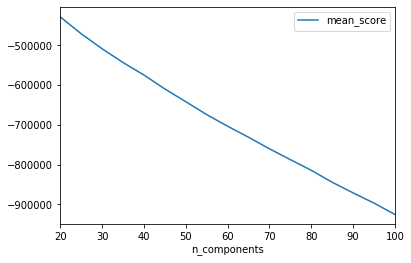

In [16]:
gs_results = gs.cv_results_

n_comps = gs_results["param_n_components"].data
scores = gs_results["mean_test_score"]

gs_eval = pd.DataFrame({"n_components": n_comps, "mean_score": scores}).set_index("n_components")
gs_eval.plot(kind="line")

Best model scores

In [15]:
# Log Likelihood (higher better)
print("Log Likelihood: ", gs.best_score_)

# Perplexity (lower better)
print("Perplexity: ", model.perplexity(tfidf_v))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Log Likelihood:  -427942.38493007707


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.5s finished


Perplexity:  360979.9650302132


# Conclusion

A scoring approach for finding the optimal number of topics in the model isn't helpful in this case (pretty linear decay of Log Likelihood with increasing n_components). Therefore a qualitative interpretation of the most promising candidates (n_components = \[20, 25, 30, 40, 50, 80, 100\]) will be done in the next iteration.